<a href="https://colab.research.google.com/github/PulkitAppz/Capstone_AIML_19B/blob/Pulkit/CapStone_Submission1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROJECT DESCRIPTION**

In this capstone project, the goal is to build a pneumonia detection system, to locate the position of
inflammation in an image.
Tissues with sparse material, such as lungs which are full of air, do not absorb the X-rays and appear
black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.
While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia
related.
In the data, some of these are labeled “Not Normal No Lung Opacity”. This extra third class indicates
that while pneumonia was determined not to be present, there was nonetheless some type of
abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.



Dicom original images: - Medical images are stored in a special format called DICOM files (*.dcm). They
contain a combination of header metadata as well as underlying raw image arrays for pixel data.


Details about the data and dataset files are given in below link,
https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data



In [1]:
# Installing pydicom to read dcm files
!pip install -q pydicom

In [2]:
# Import necessary packages/Library
import pydicom as dcm
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import os, zipfile, random, csv
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Set path to G-Drive
from google.colab import drive
drive.mount('/content/drive')
print(os. getcwd())
print(os.listdir())
os.chdir('/content/drive/My Drive/Colab Notebooks/Capstone')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
['.config', 'drive', 'sample_data']


**Download Dataset**

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pulkitswami7","key":"0396ff6b1c433f1ef961d8233d7ee37d"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
'chmod 600 /root/.kaggle/kaggle.json'

'chmod 600 /root/.kaggle/kaggle.json'

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle
!kaggle competitions download -c rsna-pneumonia-detection-challenge

Processing /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674/kaggle-1.5.6-cp36-none-any.whl
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6
100% 3.66G/3.66G [00:49<00:00, 6.44MB/s]
100% 3.66G/3.66G [00:49<00:00, 80.1MB/s]


In [ ]:
!ls


CapStone_Submission1.ipynb  kaggle.json  rsna-pneumonia-detection-challenge.zip


In [ ]:
file_name = 'rsna-pneumonia-detection-challenge.zip'
files = zipfile.ZipFile(file_name, 'r')
files.extractall()

In [ ]:
!ls


 CapStone_Submission1.ipynb		  stage_2_sample_submission.csv
'GCP Credits Request Link - RSNA.txt'	  stage_2_test_images
 kaggle.json				  stage_2_train_images
 rsna-pneumonia-detection-challenge.zip   stage_2_train_labels.csv
 stage_2_detailed_class_info.csv


**Exploring CSVs**

1. Images for the current stage in the stage_2_train_images and stage_2_test_images.

2. Training data: stage_2_train_labels.csv

3. stage_2_detailed_class_info.csv containing detailed information about the positive and negative classes in the training set

In [ ]:
print('***'*10, 'Datasets Summary', '***'*10)
train_labels = pd.read_csv('stage_2_train_labels.csv')
class_info = pd.read_csv('stage_2_detailed_class_info.csv')

print(f'Train Labels dataframe has {train_labels.shape[0]} rows and {train_labels.shape[1]} columns')#(0 for rows and 1 for columns)
print(f'Class info dataframe has {class_info.shape[0]} rows and {class_info.shape[1]} columns')


****************************** Datasets Summary ******************************
Train Labels dataframe has 30227 rows and 6 columns
Class info dataframe has 30227 rows and 2 columns


From above Output, we can say there is 30227 patients IDs or may be there is duplicate patient IDs. So, lets check below, if there is any duplicate IDs.

In [ ]:
print('No. of Unique patient IDs in train_labels:', train_labels['patientId'].nunique() )
print('No. of Unique patient IDs in class_info:', class_info['patientId'].nunique() )

No. of Unique patient IDs in train_labels: 26684
No. of Unique patient IDs in class_info: 26684


In [ ]:
print('No. of Duplicate Ids:{}' .format((30227)-(train_labels['patientId'].nunique())) )

No. of Duplicate Ids:3543


**Exploratory Data Analysis (EDA)**


In [ ]:
train_labels.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [ ]:
class_info.head(10)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


In [ ]:
import glob
imgArr = list(set(glob.glob('stage_2_train_images/'+'*.dcm')))

In [ ]:
imgArr[0]

'stage_2_train_images/333a0af1-f1cc-4394-8066-2901b01168a5.dcm'

size of DCM images is: 1024 x 1024


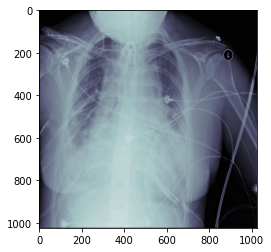

In [ ]:
img=dcm.dcmread(imgArr[5])
if 'PixelData' in img:
    rows = int(img.Rows)
    cols = int(img.Columns)
    print("size of DCM images is: {rows:d} x {cols:d}".format(rows=rows, cols=cols))
plt.imshow(img.pixel_array,cmap=plt.cm.bone)
plt.show()

In [ ]:
img

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.4271.1517874306.903139
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.4271.1517874306.903139
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

In [ ]:
# Bounding Box count 
def get_count(pathname,data_lab):
  count_path=0
  for path in data_lab['patientId']:
    path = os.path.join('stage_2_train_images/',path+'.dcm')
    if path==pathname:

      count_path+=1
  return count_path


In [ ]:
pathname = imgArr[0]
number_boundingBox=get_count(pathname,train_labels)
print('name',pathname)
print(number_boundingBox)

name stage_2_train_images/333a0af1-f1cc-4394-8066-2901b01168a5.dcm
1


In [ ]:
# function to get image
def get_image(pathname,met_data):
  for i in range(len(met_data)):
    if met_data[i]==pathname:
      img=dcm.dcmread(met_data[i]) 
      imag=img.pixel_array
  return imag

# function to draw bounding Box on images
def get_box(imag,data_lab):
  for i in range(len(data_lab)):
    path = os.path.join('stage_2_train_images/',train_labels['patientId'][i]+'.dcm')
    if path==pathname and data_lab.iloc[i]['Target']==1:
      x= int(data_lab.iloc[i]['x'])
      y= int(data_lab.iloc[i]['y'])                                                     
      w= int(data_lab.iloc[i]['width'])
      h= int(data_lab.iloc[i]['height'])
      bb=cv2.rectangle(imag,(x,y),(x+w,y+h),(255,0,0),3)
      plt.imshow(bb,cmap=plt.cm.bone)
    elif path==pathname and data_lab.iloc[i]['Target']==0:
      plt.imshow(imag,cmap=plt.cm.bone)

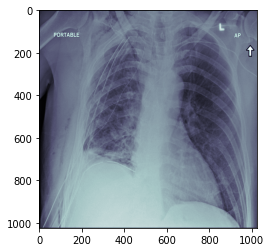

In [ ]:
import cv2
img1=get_image(pathname,imgArr)
get_box(img1,train_labels)

In [ ]:
# Merge the two dataframes
merge_df = pd.concat([train_labels, class_info['class']], axis = 1)
merge_df.head(10)


,patientId,x,y,width,height,Target,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity


In [ ]:
def image_path_arr(data_df): 
  data_df['PathName']=0
  for i in range(len(data_df)):
    data_df['PathName'][i]=os.path.join('stage_2_train_images/',data_df['patientId'][i]+'.dcm')
  return data_df

In [ ]:
data_df  = image_path_arr(merge_df)
data_df.head(10)

,patientId,x,y,width,height,Target,class,PathName
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images/0004cfab-14fd-4e49-80ba-6...
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images/00322d4d-1c29-4943-afc9-b...
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,stage_2_train_images/003d8fa0-6bf1-40ed-b54c-a...
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,stage_2_train_images/00436515-870c-4b36-a041-d...
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,stage_2_train_images/00436515-870c-4b36-a041-d...
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images/00569f44-917d-4c86-a842-8...
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images/006cec2e-6ce2-4549-bffa-e...
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,stage_2_train_images/00704310-78a8-4b38-8475-4...
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,stage_2_train_images/00704310-78a8-4b38-8475-4...


In [ ]:
img.PatientAge

'45'

In [ ]:
data_df['PathName'].isnull().sum()

0

In [ ]:
print(len(imgArr))
data_df.shape

26684


(30227, 8)

In [ ]:
data_df['Age']=0
for i in range(len(data_df)):
    df_imagePath = data_df['PathName'][i]
    print(i)
    img=dcm.dcmread(df_imagePath)
    data_df['Age'][i]=os.path.join(img.PatientAge)

  

Streaming output truncated to the last 5000 lines.
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
25282
25283
25284
25285
25286
25287
25288
25289
25290
25291
25292
25293
25294
25295
25296
25297
25298
25299
25300
25301
25302
25303
25304
25305
25306
25307
25308
25309
25310
25311
25312
25313
25314
25315
25316
25317
25318
25319
25320
25321
25322
25323
25324
25325
25326
25327
25328
25329
25330
25331
25332
25333
25334
25335
25336
25337
25338
25339
25340
25341
25342
25343
25344
25345
25346
25347
25348
25349
25350
25351
25352
25353
25354
25355
25356
25357
25358
25359
25360
25361
25362
25363
25364
25365
25366
25367
25368
25369
25370
25371
25372
25373
25374
25375
25376
25377
25378
25379
25380
25381
25382
25383
25384
25385
2

In [ ]:
data_df.head(10)

,patientId,x,y,width,height,Target,class,PathName,Age
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images/0004cfab-14fd-4e49-80ba-6...,51
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...,48
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images/00322d4d-1c29-4943-afc9-b...,19
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,stage_2_train_images/003d8fa0-6bf1-40ed-b54c-a...,28
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,stage_2_train_images/00436515-870c-4b36-a041-d...,32
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,stage_2_train_images/00436515-870c-4b36-a041-d...,32
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images/00569f44-917d-4c86-a842-8...,54
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images/006cec2e-6ce2-4549-bffa-e...,78
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,stage_2_train_images/00704310-78a8-4b38-8475-4...,75
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,stage_2_train_images/00704310-78a8-4b38-8475-4...,75


Lets find outliers in age and all other exploration based on age factor of patients.

****************************** Age outliers detection ******************************
Min age in the training dataset: 1
Max age in the training dataset: 155
75th Percentile of age in the training dataset: 59.0


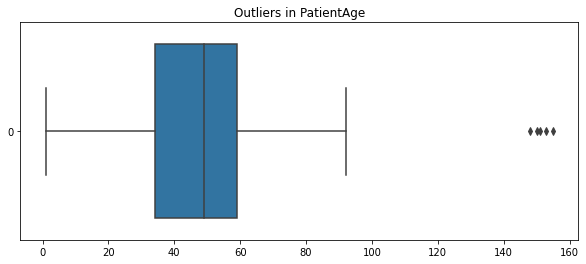

In [ ]:
print('***'*10, 'Age outliers detection', '***'*10)
print('Min age in the training dataset: {}'.format(data_df['Age'].min()))
print('Max age in the training dataset: {}'.format(data_df['Age'].max()))
print('75th Percentile of age in the training dataset: {}'.format(data_df['Age'].quantile(0.75)))

fig = plt.figure(figsize = (10, 4))
ax = sns.boxplot(data = data_df['Age'], orient = 'h').set_title('Outliers in PatientAge')

In [ ]:
#Calculate Number of outliers 

Q1 = data_df['Age'].quantile(0.25)
Q3 = data_df['Age'].quantile(0.75)
IQR = Q3 - Q1
min = Q1 - 1.5 * IQR
max = (Q3 + 1.5 * IQR)
print('No. of outliers:',((data_df['Age'] < (Q1 - 1.5 * IQR)) | (data_df['Age'] > (Q3 + 1.5 * IQR))).sum())


No. of outliers: 5


In [ ]:
data_df['Age'].describe().astype(int)

count    30227
mean        46
std         16
min          1
25%         34
50%         49
75%         59
max        155
Name: Age, dtype: int64

Why I did above analysis,it is because I already saw the age of a patient is 155 which in not does not look real. So, I plot boxplot to find all the outliers. Now, I will handle the outliers buy fixing the age to 105 which can be feasible in real world. 

In [ ]:
count = 0
for i in range(len(data_df.Age)):
  if data_df.Age[i]>105:
    count = count + 1
    data_df.Age[i] = 105
    if count == 5:# bcz only 5 outliers 
      break
data_df['Age'].describe().astype(int)


count    30227
mean        46
std         16
min          1
25%         34
50%         49
75%         59
max        105
Name: Age, dtype: int64

**Now let's  Visualise the Age.**

(43.0, 63.0]     13919
(22.0, 43.0]      8766
(63.0, 84.0]      4881
(1.0, 22.0]       2551
(84.0, 105.0]      110
Name: Age, dtype: int64

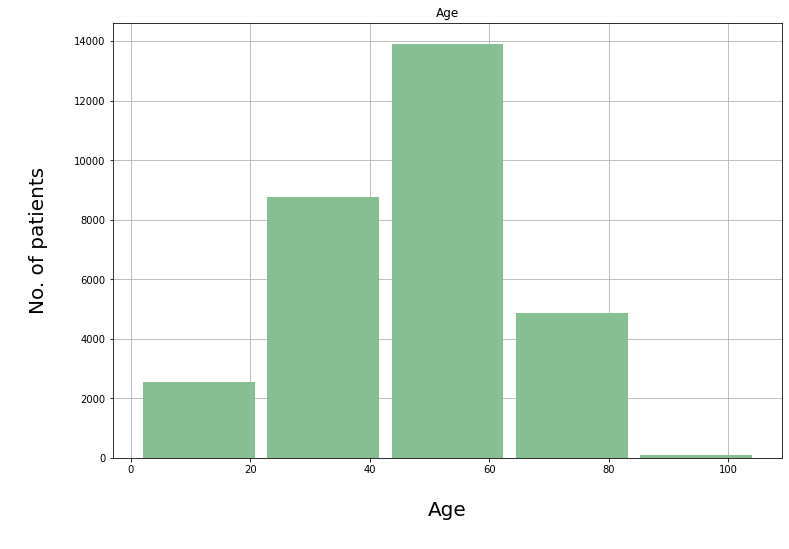

In [ ]:
ax = data_df.hist(column='Age', bins=5, grid=True, figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
plt.xlabel('\nAge\n', fontsize = 20)
plt.ylabel('\nNo. of patients\n', fontsize = 20)

arr = pd.cut(data_df['Age'], bins = 5, precision = 0)
arr.value_counts()



**Saving data_df dataframe as upadted datafram. The Reason why I am doing this is everytime Google colabs disconnect, I need to run all previous cells.**

In [ ]:

data_df['Gender']=0
for i in range(len(data_df)):
    df_imagePath = data_df['PathName'][i]
    img=dcm.dcmread(df_imagePath)
    data_df['Gender'][i]=os.path.join(img.PatientSex)


In [ ]:
data_df.to_csv('updated_dataframe.csv')

In [ ]:
data_df.head()

,patientId,x,y,width,height,Target,class,PathName,Age,Gender
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images/0004cfab-14fd-4e49-80ba-6...,51,F
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images/00313ee0-9eaa-42f4-b0ab-c...,48,F
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,stage_2_train_images/00322d4d-1c29-4943-afc9-b...,19,M
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,stage_2_train_images/003d8fa0-6bf1-40ed-b54c-a...,28,M
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,stage_2_train_images/00436515-870c-4b36-a041-d...,32,F


***Exploring data on the bases of Gender***

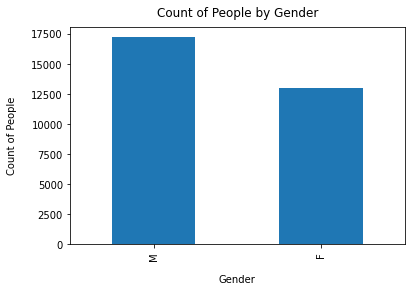

In [13]:
data_df = pd.read_csv(('updated_dataframe.csv'))
data_df['Gender'].value_counts().plot(kind='bar');
plt.xlabel("Gender", labelpad=14)
plt.ylabel("Count of People", labelpad=14)
plt.title("Count of People by Gender", y=1.02);

No. of male and female having lung opacity
 M    5560
F    3995
Name: Gender, dtype: int64


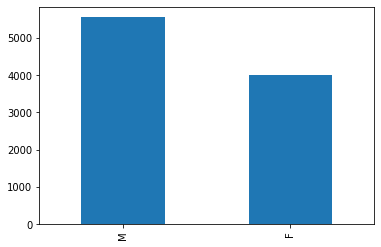

In [ ]:
print('No. of male and female having lung opacity\n',data_df.loc[(data_df['Target'] == 1), 'Gender'].value_counts())
data_df.loc[(data_df['Target'] == 1), 'Gender'].value_counts().plot(kind='bar')


***Visualizing image on the basis of class***(Normal, No Lung Opacity / Not Normal and Lung Opacity)

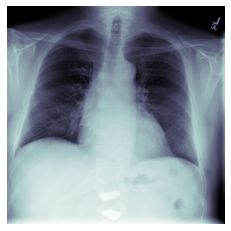

In [ ]:
normal_img = data_df.loc[data_df['class'] == 'Normal'].iloc[1]
normal_img_data = dcm.dcmread(normal_img['PathName'])
plt.imshow(normal_img_data.pixel_array,cmap=plt.cm.bone)
#plt.title('Normal')
plt.axis('off')
plt.show()


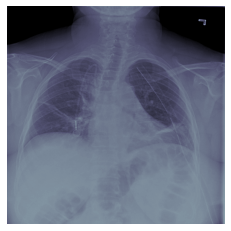

In [ ]:
normal_img = data_df.loc[data_df['class'] == 'No Lung Opacity / Not Normal'].iloc[1]
normal_img_data = dcm.dcmread(normal_img['PathName'])
plt.imshow(normal_img_data.pixel_array,cmap=plt.cm.bone)
#plt.title('No Lung Opacity / Not Normal')
plt.axis('off')
plt.show()

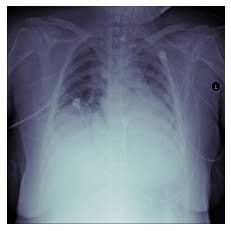

In [ ]:
normal_img = data_df.loc[data_df['class'] == 'Lung Opacity'].iloc[1]
normal_img_data = dcm.dcmread(normal_img['PathName'])
plt.imshow(normal_img_data.pixel_array,cmap=plt.cm.bone)
#plt.title('No Lung Opacity / Not Normal')
plt.axis('off')
plt.show()

# **Data Prepration (train and validation splitting )**

In [7]:
image_name = os.listdir('stage_2_train_images/')

In [8]:
def get_pneumonia_evidence(filename):
    pneumonia_evidence = {}
    df = pd.read_csv(filename)

    for _, row in df.iterrows():
        fn = row[0]
        loc = row[1:5]
        pneumonia = row[5]
        if pneumonia == 1:
            loc = [int(float(i)) for i in loc]
            if fn in pneumonia_evidence:
                pneumonia_evidence[fn].append(loc)
            else:
                pneumonia_evidence[fn] = [loc]
    return pneumonia_evidence

In [9]:
pneumonia_evidence = get_pneumonia_evidence(filename = 'stage_2_train_labels.csv')


In [15]:
import keras
from skimage.transform import resize
import cv2
class generate(keras.utils.Sequence):#reference kaggle

    def __init__(self, folder, fns, pneumonia_evidence = None, 
                 batch_size = 32, image_size = 256, 
                 shuffle = True, augment = False, predict = False):
        self.folder = folder
        self.fns = fns
        self.pneumonia_evidence = pneumonia_evidence
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()

    def __load__(self, fn):
        img = dcm.dcmread(os.path.join(self.folder, fn)).pixel_array
        msk = np.zeros(img.shape)
        fn = fn.split('.')[0]
        if fn in self.pneumonia_evidence:
            for loc in self.pneumonia_evidence[fn]:
                x, y, w, h = loc
                msk[y:y+h, x:x+w] = 1
        img = resize(img, (self.image_size, self.image_size), mode = 'reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode = 'reflect') > 0.5
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk

    

In [11]:
def plot_masks(df, path, image_fns, pneumonia_evidence):
    sample_patient_id = random.choice(list(df.loc[(df['Target'] == 1), 'patientId']))
    sample_fn = sample_patient_id + '.dcm'
    sample_details = df.loc[df['patientId'] == sample_patient_id]
    
    g = generate(path, image_fns, pneumonia_evidence)
    img, msk = g.__load__(sample_fn)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 6))
    
    _ = ax1.imshow(img[:,:,0], cmap = plt.cm.bone); _ = ax1.axis('off')
    _ = ax2.imshow(msk[:,:,0]); _ = ax2.axis('off')
    _ = ax3.imshow(cv2.bitwise_and(img, img, mask = msk.astype(np.uint8)), 
                cmap = plt.cm.bone); _ = ax3.axis('off')
    _ = ax1.set_title('{}\nAge: {}, Gender: {},\nSample Image'.format(sample_patient_id,
                list(sample_details['Age'].unique())[0], 
                list(sample_details['Gender'].unique())[0]))
    _ = ax2.set_title('{}\nAge: {}, Gender: {}, \nMask for Sample Image'.format(sample_patient_id,
                list(sample_details['Age'].unique())[0], 
                list(sample_details['Gender'].unique())[0]))
    _ = ax3.set_title('{}\nAge: {}, Gender: {} \nMask overlay over Image'.format(sample_patient_id,
                list(sample_details['Age'].unique())[0], 
                list(sample_details['Gender'].unique())[0]
                ))
    plt.subplots_adjust(top = 0.4)
    plt.tight_layout()

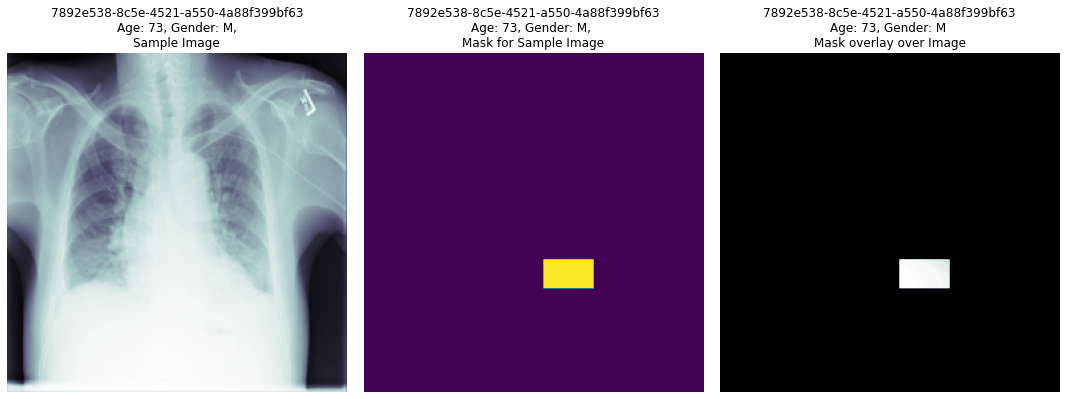

In [16]:
plot_masks(data_df, 'stage_2_train_images/', image_name, pneumonia_evidence)

# **CNN MODEL**

In [4]:
import tensorflow as tf
from tensorflow import keras
import keras
from skimage.transform import resize
import cv2

In [5]:
# empty dictionary
pneumonia_locations = {}
# load table
with open(os.path.join('stage_2_train_labels.csv'), mode='r') as infile:
    # open reader
    reader = csv.reader(infile)
    # skip header
    next(reader, None)
    # loop through rows
    for rows in reader:
        # retrieve information
        filename = rows[0]
        location = rows[1:5]
        pneumonia = rows[5]
        # if row contains pneumonia add label to dictionary
        # which contains a list of pneumonia locations per filename
        if pneumonia == '1':
            # convert string to float to int
            location = [int(float(i)) for i in location]
            # save pneumonia location in dictionary
            if filename in pneumonia_locations:
                pneumonia_locations[filename].append(location)
            else:
                pneumonia_locations[filename] = [location]

In [6]:
# load and shuffle filenames
folder = 'stage_2_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = 2560
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples
print('Total train images:',len(filenames))
print('Images with pneumonia:', len(pneumonia_locations))

n train samples 24124
n valid samples 2560
Total train images: 26684
Images with pneumonia: 6012


In [10]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=32, image_size=128, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = dcm.dcmread(os.path.join(self.folder, filename)).pixel_array
        # create empty mask
        msk = np.zeros(img.shape)
        # get filename without extension
        filename = filename.split('.')[0]
        # if image contains pneumonia
        if filename in self.pneumonia_locations:
            # loop through pneumonia
            for location in self.pneumonia_locations[filename]:
                # add 1's at the location of the pneumonia
                x, y, w, h = location
                msk[y:y+h, x:x+w] = 1
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        msk = resize(msk, (self.image_size, self.image_size), mode='reflect') > 0.5
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            img = np.fliplr(img)
            msk = np.fliplr(msk)
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        msk = np.expand_dims(msk, -1)
        return img, msk
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = dcm.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            # unzip images and masks
            imgs, msks = zip(*items)
            # create numpy batch
            imgs = np.array(imgs)
            msks = np.array(msks)
            return imgs, msks
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

In [11]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

# create network and compiler
model = create_network(input_size=128, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])
model.summary()
# cosine learning rate annealing
def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2
learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

# create train and validation generators
folder = 'stage_2_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=32, image_size=128, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=32, image_size=128, shuffle=False, predict=False)

history = model.fit(train_gen, validation_data=valid_gen, callbacks=[learning_rate], epochs=25, workers=4, use_multiprocessing=True)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 128, 128, 32) 288         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_21 (BatchNo (None, 128, 128, 32) 128         conv2d_22[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_21 (LeakyReLU)      (None, 128, 128, 32) 0           batch_normalization_21[0][0]     
_______________________________________________________________________________________